In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
import datajoint as dj
import h5py
import sys
import pandas as pd
import shutil
import pickle

from djimaging.user.alpha.utils import database

# Set these to change what cell you want
date = "2020-08-29"
stimulus = "noise_1500"
exp_num = "1"
cell_id = date + "_" + exp_num
field_stim_extract = "d1"  # Assume stimuli are all the same with each ROI


# Get the current working directory
cwd = os.getcwd()

# Get the username
username = os.popen('whoami').read().strip()

# Get the home directory
home_directory = os.path.expanduser("~")
print(username, home_directory)

# Set the path to the data directory where results will be stored
base_dir = f'{home_directory}/GitRepos/jaxley_rgc/deistler_our_data_and_morph'
assert os.path.exists(base_dir), f'{base_dir} does not exist.'
  





# Set config file
config_file = f'{home_directory}/datajoint/dj_{username}_conf.json'
assert os.path.isfile(config_file), f'Set the path to your config file: {config_file}'

# Path to djimaging
path_to_djimaging = f'{home_directory}/GitRepos/s-on-alpha-regional/code/AlphaDjimaging/djimaging'

# Set schema name
schema_name = 'ageuler_joesterle_alpha_ca'
indicator = 'calcium'
database.connect_dj(indicator=indicator)


/gpfs01/euler/User/ssuhai/GitRepos/s-on-alpha-regional/code/AlphaDjimaging/djimaging/autorois/roi_canvas.py:24: UserWarning: Failed to import ipycanvas. AutoROIs will not work.
  warnings.warn('Failed to import ipycanvas. AutoROIs will not work.')
[2025-02-11 10:56:20,382][INFO]: Connecting ssuhai@172.25.240.200:3306
[2025-02-11 10:56:20,431][INFO]: Connected ssuhai@172.25.240.200:3306


ssuhai /gpfs01/euler/User/ssuhai
schema_name: ageuler_joesterle_alpha_ca
dataset: calcium


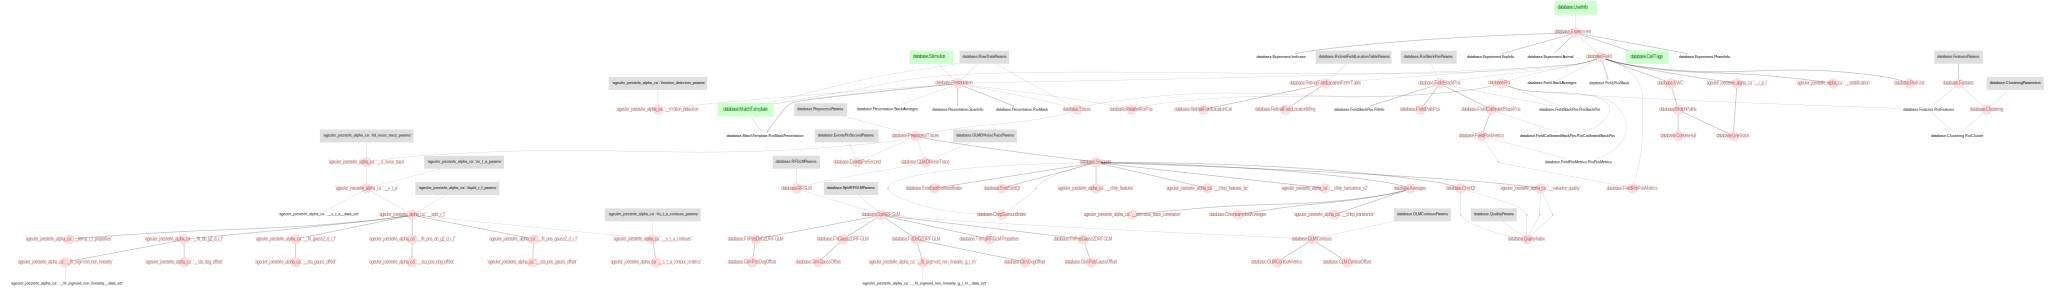

In [4]:
dj.ERD(database)

In [8]:
(database.Presentation() & f'date="2020-07-08"' & f'stim_name="{stimulus}"' & f'field="d2"')

experimenter name of the experimenter,date date of recording,exp_num experiment number in a day,field string identifying files corresponding to field,stim_name Unique string identifier,raw_id unique param set id,cond1 cond1 (pharmacological or other),h5_header path to h5 file,trigger_flag Are triggers as expected (1) or not (0)?,triggertimes triggertimes in each presentation,triggervalues values of the recorded triggers,scan_type Type of scan,npixartifact Number of pixel with light artifact,pixel_size_um width / height of a pixel in um,z_step_um z-step in um
Ran,2020-07-08,1,d2,noise_1500,1,control,/gpfs01/euler/data/Data/Ran/20200708/1/Pre/SMP_C1_d2_Dnoise.h5,1,=BLOB=,=BLOB=,xy,3,0.558594,1.0


In [5]:
stim_path = (database.Presentation() & f'date="{date}"' & f'stim_name="{stimulus}"' & f'field="{field_stim_extract}"').fetch1()['h5_header']

print(stim_path)

/gpfs01/euler/data/Data/Ran/20200829/1/Pre/SMP_C1_d1_Dnoise.h5


In [23]:
file1 = h5py.File('/gpfs01/euler/User/ssuhai/GitRepos/jaxley_rgc/deistler_our_data_and_morph/data/SMP_C1_d2_Dnoise.h5', 'r')
noise_stimulus1 = file1["NoiseArray3D"][()]
file2 = h5py.File('/gpfs01/euler/User/ssuhai/GitRepos/jaxley_rgc/deistler_our_data_and_morph/data/noise.h5', 'r')
noise_stimulus2 = file2["NoiseArray3D"][()]



In [24]:
(noise_stimulus1 == noise_stimulus2).all()

np.True_

In [27]:
# load the labels
with open('/gpfs01/euler/User/ssuhai/GitRepos/jaxley_rgc/deistler_our_data_and_morph/results/data/labels_lowpass_2020-08-29_1.pkl','rb') as handle:
    labels = pickle.load(handle)

In [54]:
ca = np.array(labels.loc[(labels['rec_id']==1) & (labels['roi_id']==1)]['ca'].values[0])
ca.shape



(1498,)

In [55]:
def get_rf_from_weighted_image_average(labels,noise_img,rec_id,roi_id,start_idx,stop_idx):
    ca = np.array(labels.loc[(labels['rec_id']==rec_id) & (labels['roi_id']==roi_id)]['ca'].values[0])
    ca = np.array(ca)
    
    weighted_image = noise_img[:,:,start_idx:stop_idx] * ca[np.newaxis,np.newaxis,start_idx:stop_idx] 
    rf = np.mean(weighted_image,axis=2)

    return rf



In [88]:
labels['rec_id'].unique()

array([0, 1, 2, 3])

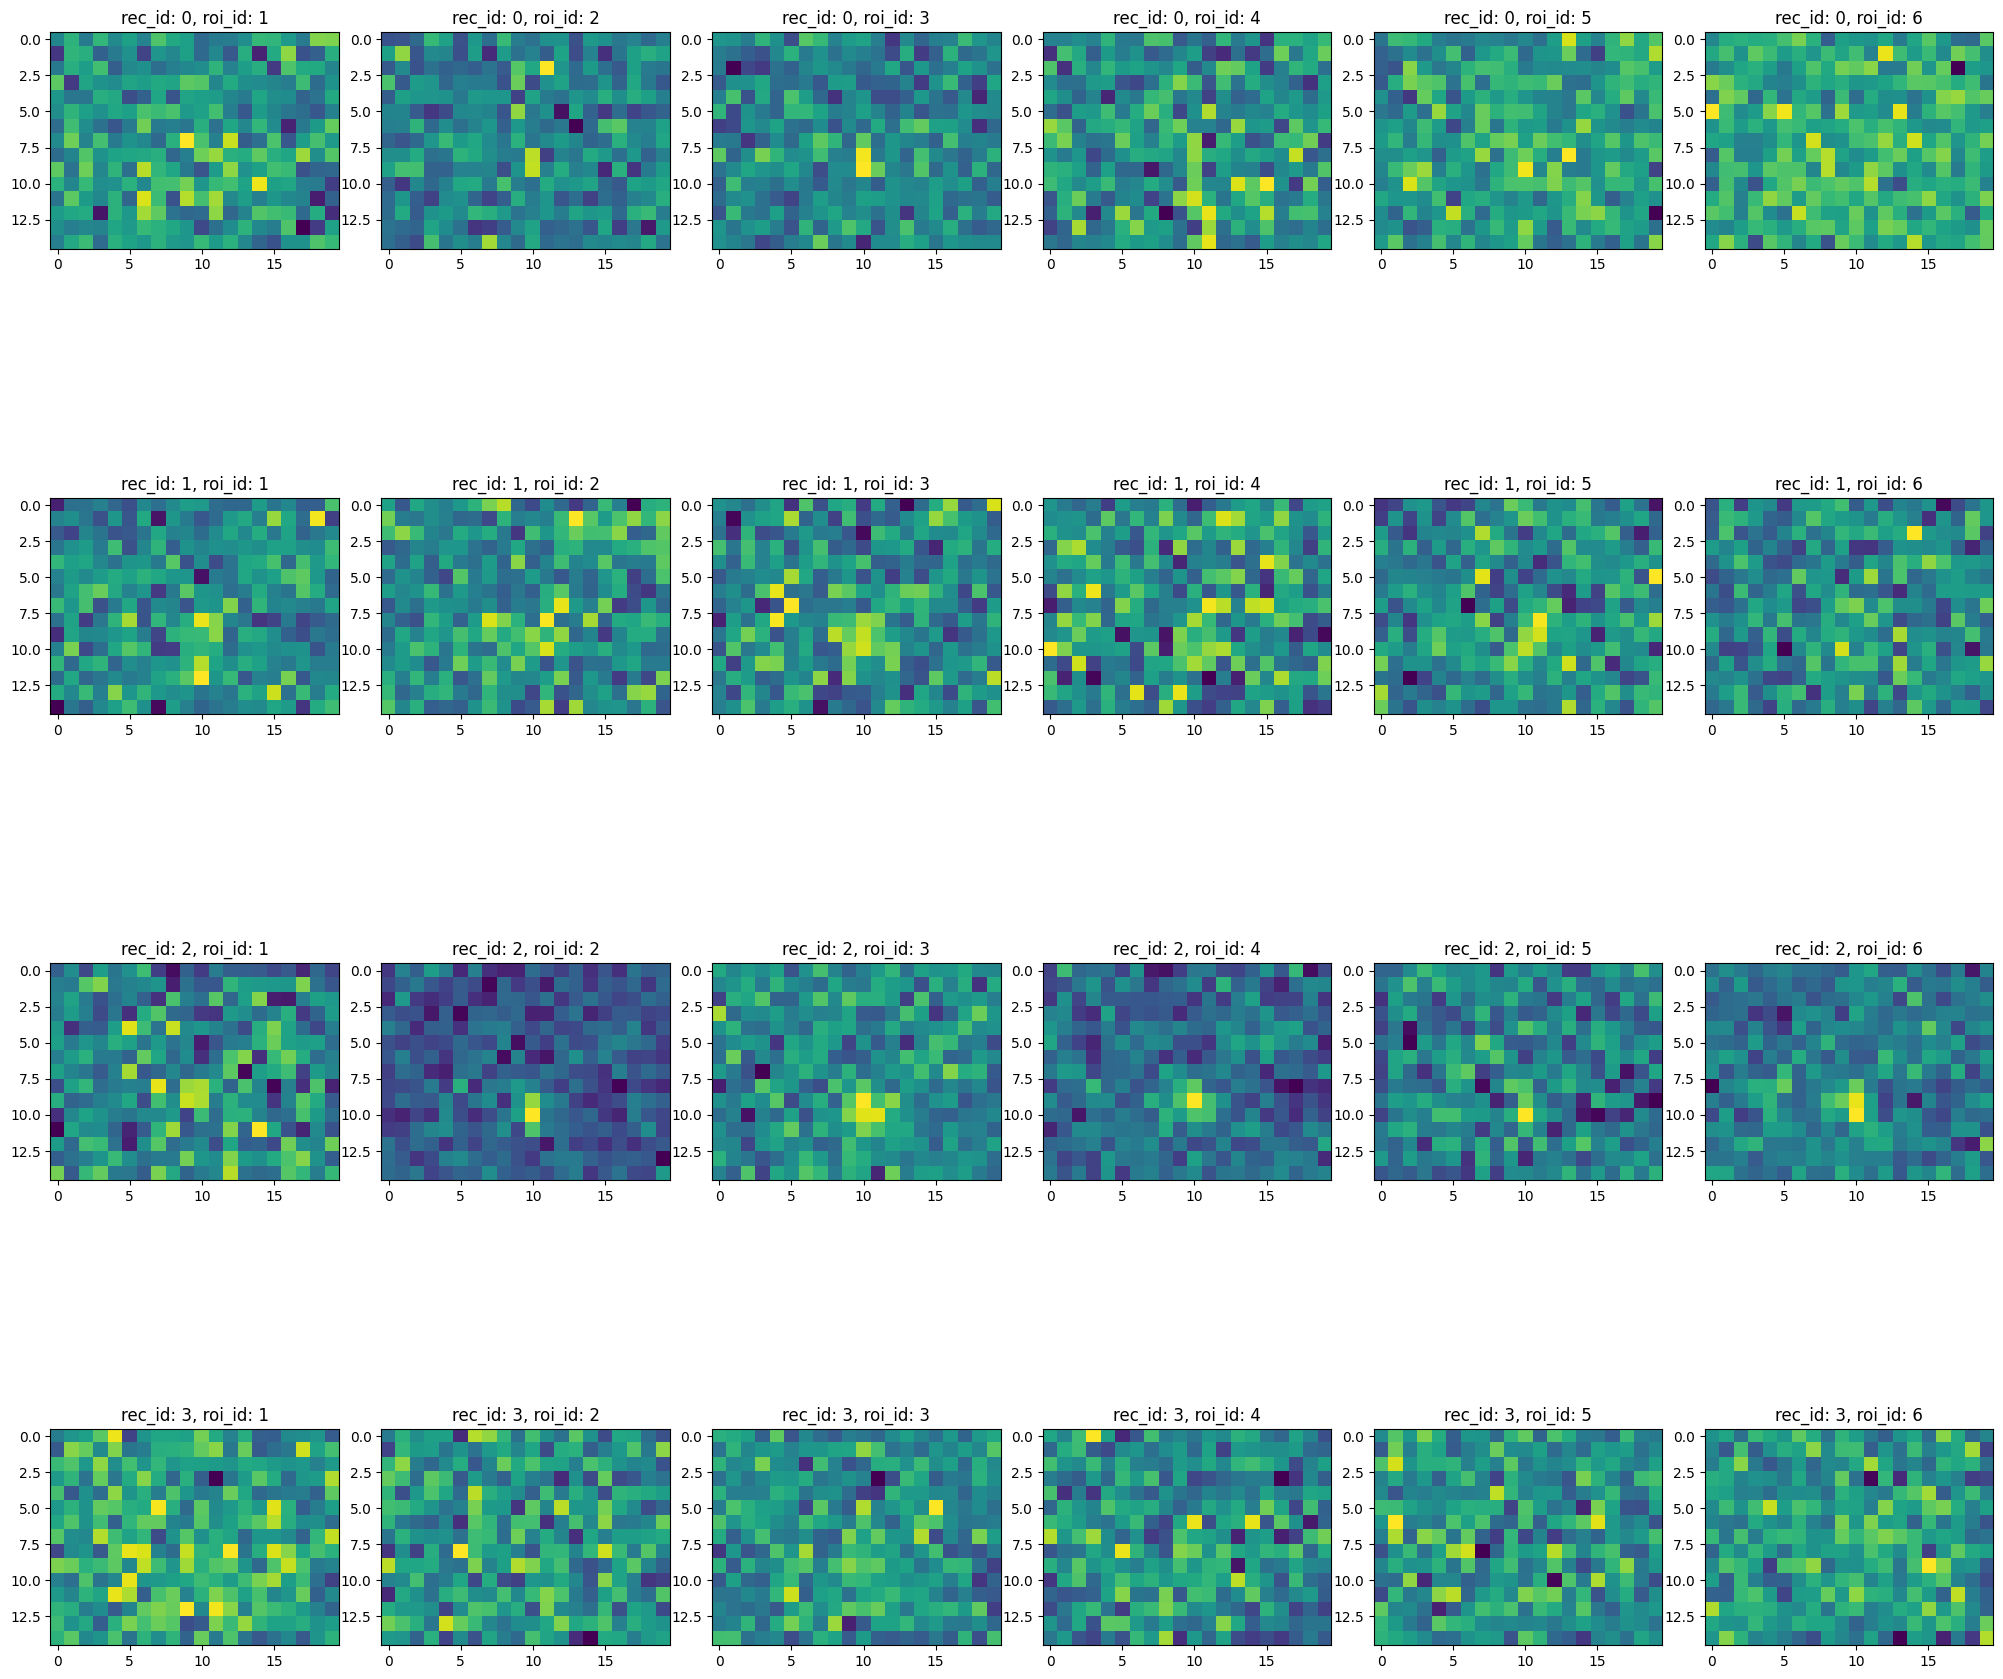

In [92]:
fig, ax = plt.subplots(4, 6, figsize=(20, 20))
ax = ax.flatten()
for rec_id in range(0, 4):
    max_roi = np.max(labels.loc[labels['rec_id'] == rec_id]['roi_id'].values)
    for roi_id in range(1, max_roi + 1):
        rf = get_rf_from_weighted_image_average(labels, noise_stimulus1, rec_id, roi_id, start_idx=100, stop_idx=1000)
        ax_index = (rec_id) * 6 + (roi_id - 1)
        ax[ax_index].imshow(rf)
        ax[ax_index].set_title(f'rec_id: {rec_id}, roi_id: {roi_id}')
plt.tight_layout()
plt.show()
